In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_selector, make_column_transformer

In [2]:
ts1 = pd.read_csv(r"Data/TS1.csv", encoding='unicode_escape')
ts2 = pd.read_csv(r"Data/TS2.csv", encoding='unicode_escape')
ts8 = pd.read_csv(r"Data/TS8.csv", encoding='unicode_escape', on_bad_lines='skip', low_memory=False)

## Data Cleaning

In [3]:
ts1.head()

,Rep,Cust,Customer Name,Group,Part Number,Description,Doc,Line,Date,Time,Qty,Unit,Disc%,Cost,Range
0,2,193750,ROCK AUTO LLC,ACC,ACC31019,LITERIDER 73-96 F-Series,01V4661208,1,Nov 07 22,08:22,1,308.74,NaN,262.33,0028
1,2,193750,ROCK AUTO LLC,ACC,ACC31029,LITERIDER 73-96 F-Series,01V4786521,2,Jan 04 23,16:33,1,296.23,NaN,248.63,0028
2,2,193750,ROCK AUTO LLC,ACC,ACC31109,LITERIDER 82-11 Ranger &,01V4689424,1,Nov 20 22,15:23,1,283.15,NaN,237.97,0028
3,2,193750,ROCK AUTO LLC,ACC,ACC31109,LITERIDER 82-11 Ranger &,01V4771133,1,Dec 29 22,08:28,1,283.15,NaN,236.97,0028
4,2,193750,ROCK AUTO LLC,ACC,ACC31129,LITERIDER 01-06 Explorer,01V4683310,1,Nov 16 22,15:27,1,283.15,NaN,243.50,0028


In [4]:
ts1.drop(columns=['Rep', 'Cust', 'Customer Name', 'Description', 'Doc', 'Disc%', 'Range'], inplace=True)
ts2.drop(columns=['Rep', 'Cust', 'Customer Name', 'Description', 'Doc', 'Disc%', 'Range'], inplace=True)
ts8.drop(columns=['Rep', 'Cust', 'Customer Name', 'Description', 'Doc', 'Disc%', 'Range'], inplace=True)

In [5]:
df_list = [ts1, ts2, ts8]

for i in df_list:
    print(f'Missing Values: {i.isnull().sum()}')

Missing Values: Group          8
Part Number    0
Line           0
Date           0
Time           0
Qty            0
Unit           0
Cost           0
dtype: int64
Missing Values: Group          1
Part Number    0
Line           0
Date           0
Time           0
Qty            0
Unit           0
Cost           0
dtype: int64
Missing Values: Group           1
Part Number     0
Line            0
Date            0
Time            0
Qty             0
Unit           21
Cost            0
dtype: int64


In [6]:
for i in df_list:
    i.dropna(inplace=True)

In [7]:
df_list = [ts1, ts2, ts8]

for i in df_list:
    print(f'Missing Values: {i.isnull().sum()}')

Missing Values: Group          0
Part Number    0
Line           0
Date           0
Time           0
Qty            0
Unit           0
Cost           0
dtype: int64
Missing Values: Group          0
Part Number    0
Line           0
Date           0
Time           0
Qty            0
Unit           0
Cost           0
dtype: int64
Missing Values: Group          0
Part Number    0
Line           0
Date           0
Time           0
Qty            0
Unit           0
Cost           0
dtype: int64


In [8]:
for i in df_list:
    print(f'Duplicate Values: {i.duplicated().sum()}')

Duplicate Values: 737
Duplicate Values: 639
Duplicate Values: 540


In [9]:
for i in df_list:
    i.drop_duplicates(inplace=True)

In [10]:
for i in df_list:
    print(f'Duplicate Values: {i.duplicated().sum()}')

Duplicate Values: 0
Duplicate Values: 0
Duplicate Values: 0


In [11]:
for i in df_list:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222302 entries, 0 to 223046
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Group        222302 non-null  object 
 1   Part Number  222302 non-null  object 
 2   Line         222302 non-null  int64  
 3   Date         222302 non-null  object 
 4   Time         222302 non-null  object 
 5   Qty          222302 non-null  int64  
 6   Unit         222302 non-null  float64
 7   Cost         222302 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 15.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 163148 entries, 0 to 163787
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Group        163148 non-null  object 
 1   Part Number  163148 non-null  object 
 2   Line         163148 non-null  int64  
 3   Date         163148 non-null  object 
 4   Time         163148

In [12]:
ts8['Cost'] = ts8['Cost'].astype(float)
ts8['Line'] = ts8['Line'].astype(float)

In [13]:
for i in df_list:
    i['Date'] = pd.to_datetime(i['Date'])

In [14]:
for i in df_list:
    i.set_index(['Group', 'Date'], inplace=True)

In [15]:
ts8.head()

Part Number  Line   Time  Qty    Unit    Cost
Group Date                                                    
AAE   2022-11-06    AAE3004N   1.0  16:46  1.0  292.05  263.11
      2022-12-08    AAE3004N   1.0  16:20  1.0  292.05  263.11
      2023-01-03    AAE3004N   1.0  08:40  1.0  292.05  263.11
      2023-01-05    AAE3004N   1.0  08:13  1.0  292.05  263.11
      2023-01-29    AAE3004N   1.0  17:14  1.0  292.05  263.11

In [16]:
plot_ts1 = ts1.loc['SKP']
plot_ts2 = ts2.loc['SKP']
plot_ts8 = ts8.loc['SKP']

In [17]:
skp_ts1 = plot_ts1.groupby('Date').sum()
skp_ts2 = plot_ts2.groupby('Date').sum()
skp_ts8 = plot_ts8.groupby('Date').sum()

In [18]:
def plot_results(data_list, y, titles):
    with plt.style.context(['seaborn-muted', 'dark_background']):
        fig, ax = plt.subplots(3,1,figsize=(20,15))
        ax = ax.ravel()

        for i, data in enumerate(data_list):

            sns.lineplot(data=data, x=data.index, y=y, ax=ax[i], zorder=3, marker='o')
            
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
            ax[i].set_xlim(data.index.min(), data.index.max())
            ax[i].set_xlabel('Dates Bimonthly', fontsize=12)
            ax[i].set_ylim(data[y].min(), data[y].max())
            ax[i].grid(zorder=0, alpha=0.5, color='grey', linestyle='--')

            if y == 'Cost':
                ax[i].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
                ax[i].set_ylabel('RockAuto Product Sales Bimonthly', fontsize=12)
                pass
            else:
                ax[i].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
                ax[i].set_ylabel(f"{y}s Per Invoiced Product Sale", fontsize=12)
                pass
                
            for i in range(len(titles)):
                ax[i].set_title(f'({titles[i]}) Product Sales by Date and Customer', fontsize=20)
            
            ax[i].tick_params(axis='both', which='major', labelsize=12)
            
    plt.tight_layout()
    plt.show()

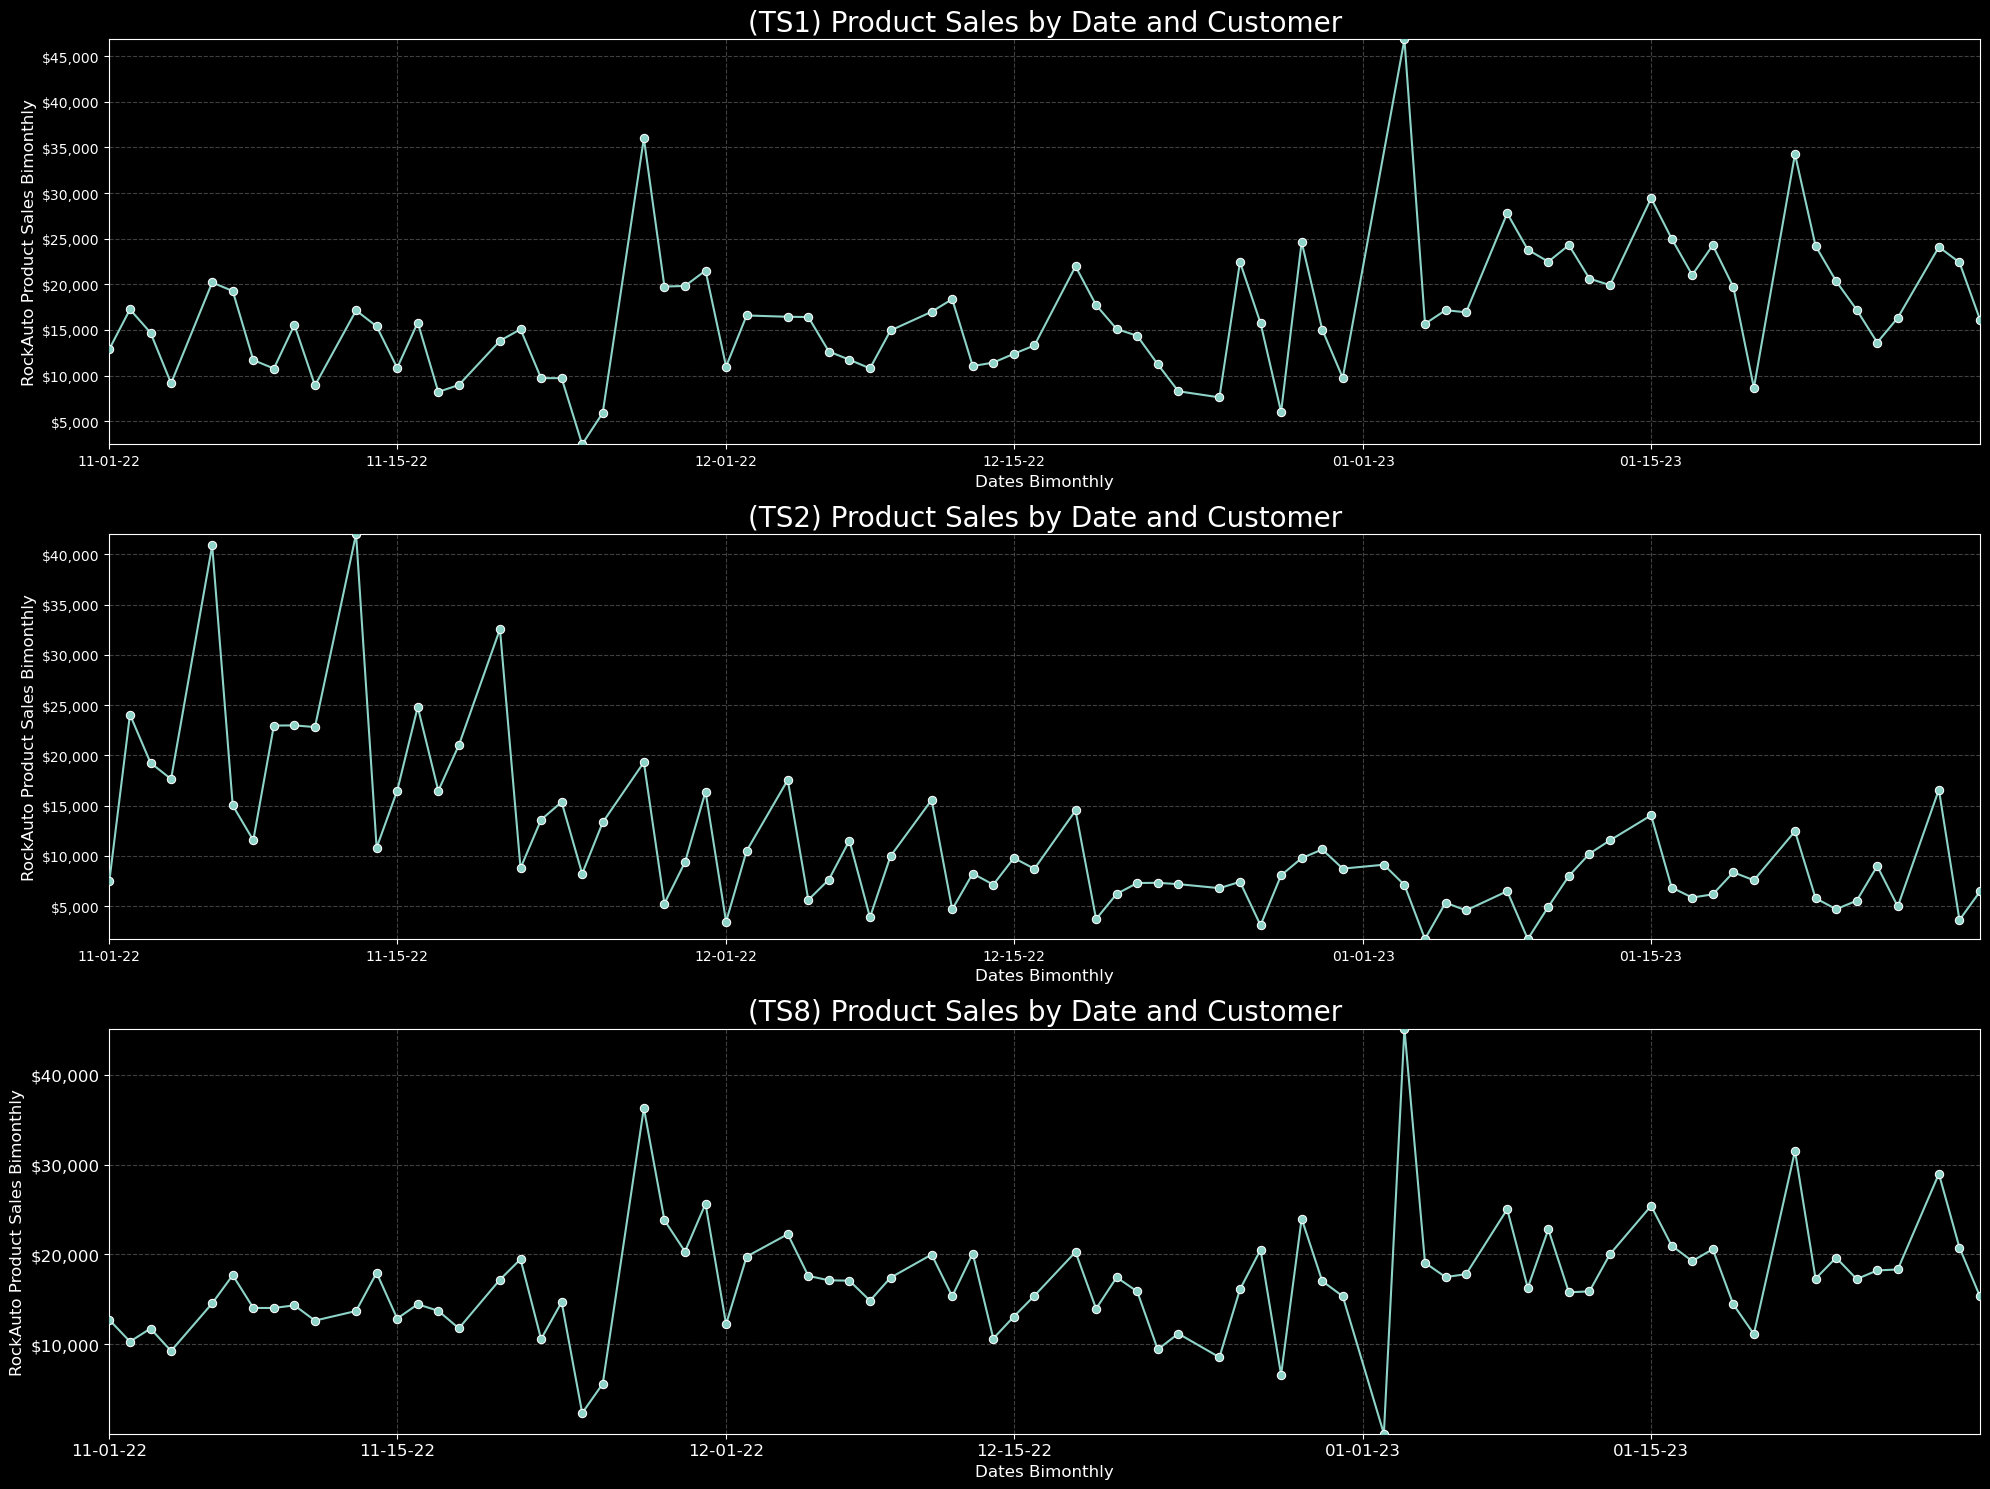

In [19]:
plot_results([skp_ts1, skp_ts2, skp_ts8], 'Cost', ['TS1', 'TS2', 'TS8'])

In [20]:
plot_ts1 = ts1.groupby('Date').sum()
plot_ts2 = ts2.groupby('Date').sum()
plot_ts8 = ts8.groupby('Date').sum()

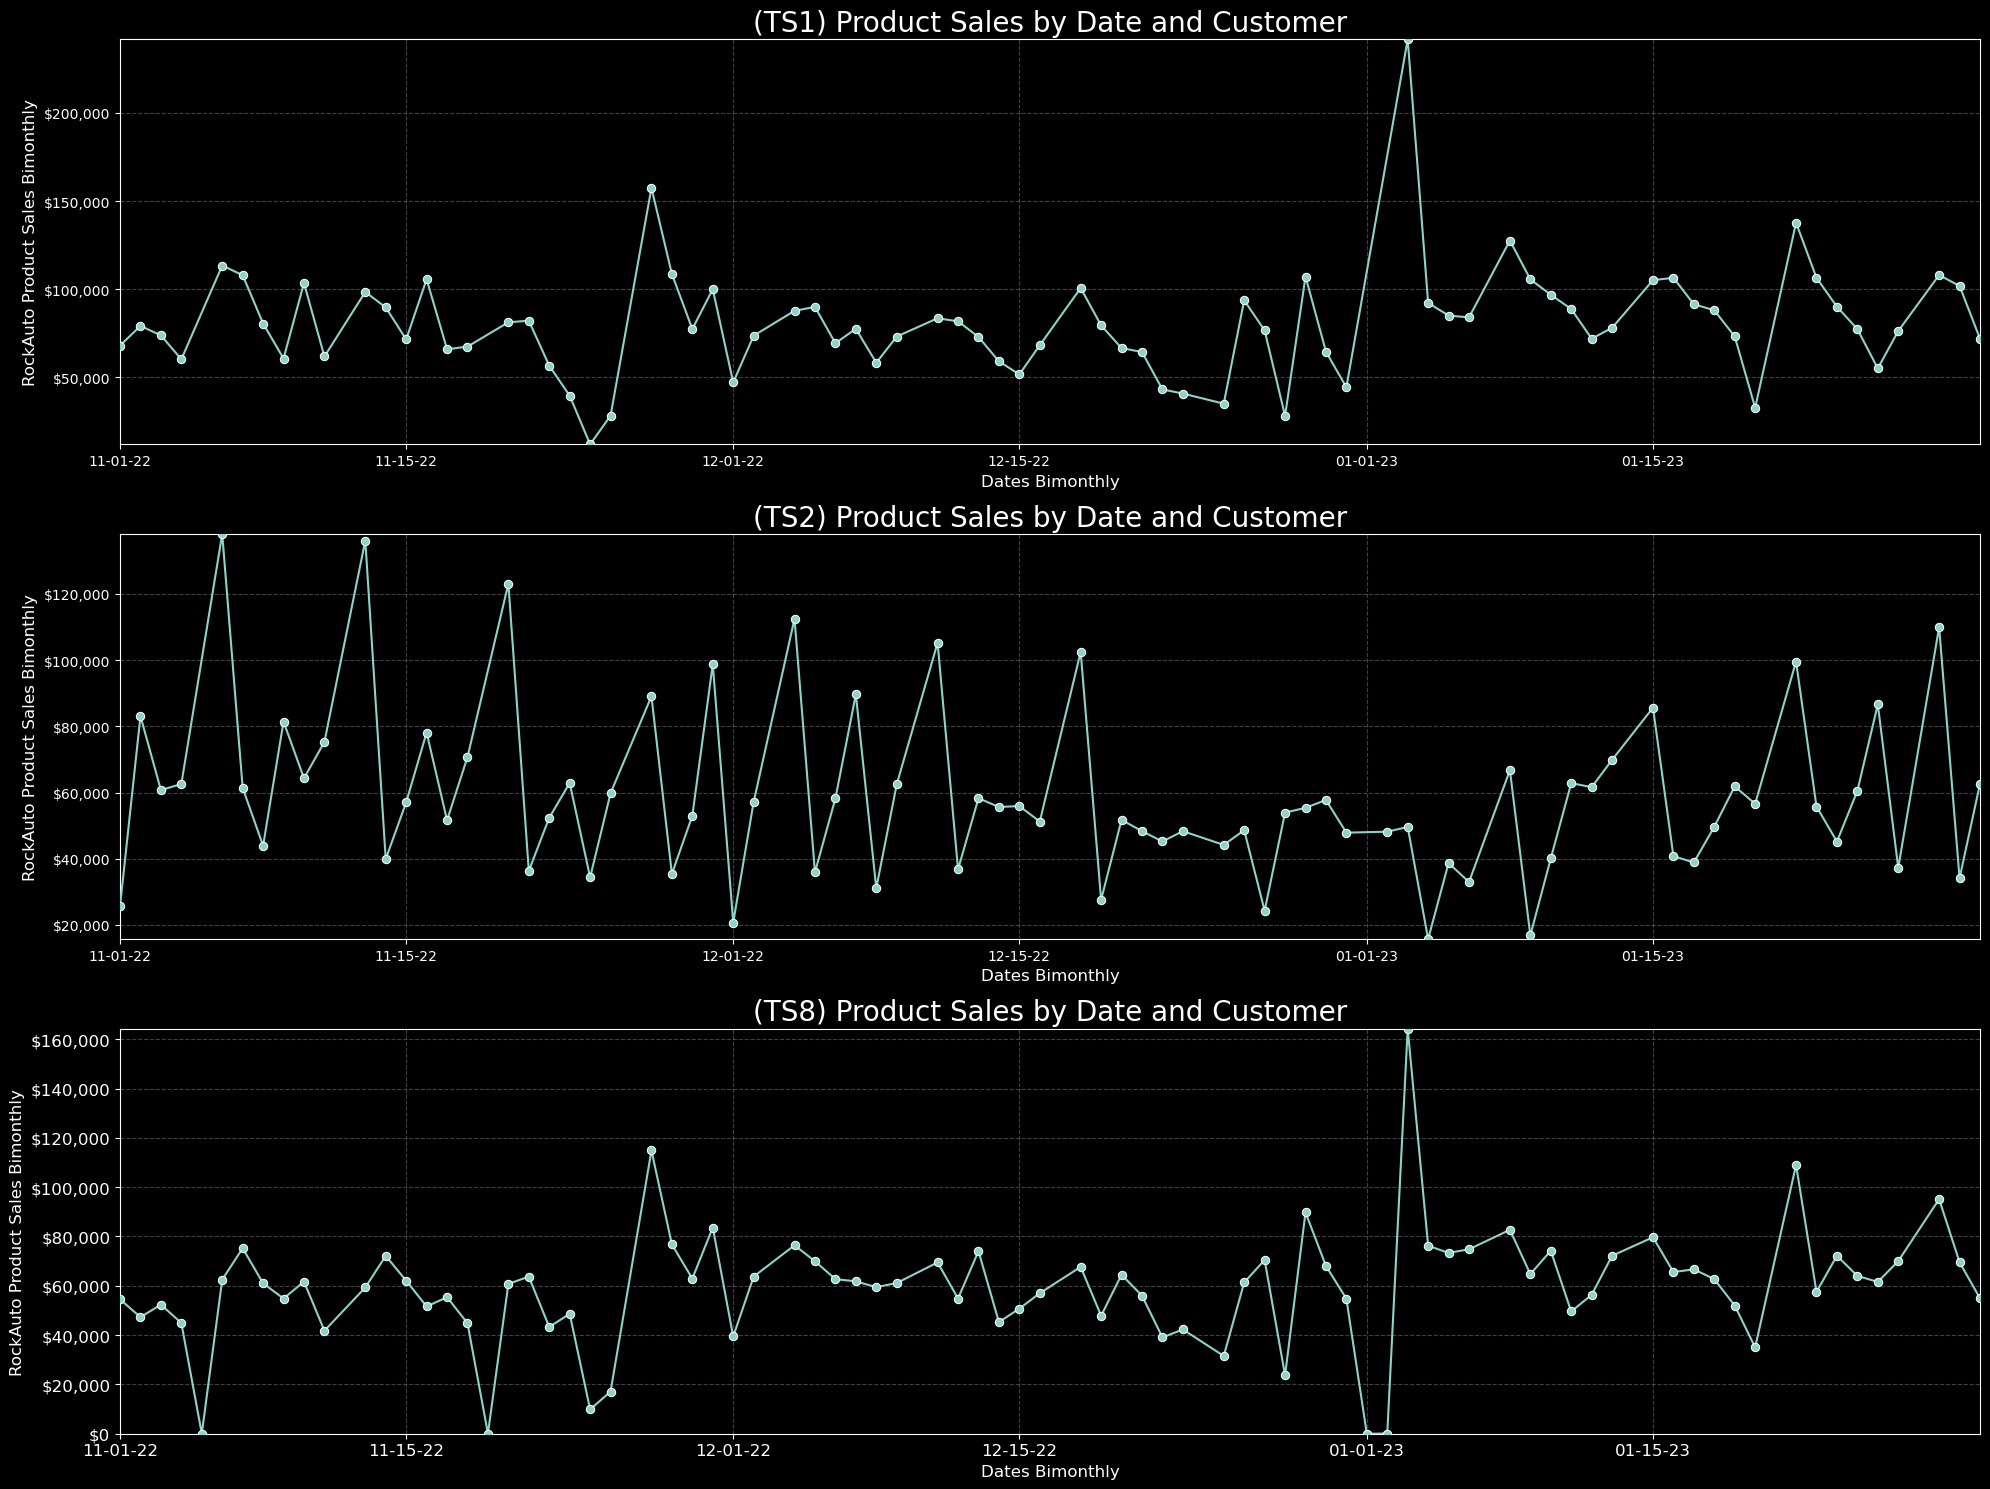

In [21]:
plot_results([plot_ts1, plot_ts2, plot_ts8], 'Cost', ['TS1', 'TS2', 'TS8'])

In [22]:
def density_plot(data_list, y, titles):
    with plt.style.context(['seaborn-muted', 'dark_background']):

        fig, ax = plt.subplots(3,1,figsize=(20,15))

        ax = ax.ravel()

        for i, data in enumerate(data_list):
            
            sns.kdeplot(data=data, x=y, ax=ax[i], fill=True, bw_method=0.05)
            ax[i].set_ylabel('')
            ax[i].set_yticks([])

            if y == 'Cost':
                ax[i].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
                ax[i].set_xlabel('RockAuto Product Sales Bimonthly', fontsize=12)
                pass
            else:
                ax[i].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
                ax[i].set_xlabel(f"{y}s Per Invoiced Product Sale", fontsize=12)
                pass

            ax[i].grid(zorder=0, alpha=0.5, color='grey', linestyle='--')

            for i in range(len(titles)):
                ax[i].set_title(f'({titles[i]})', fontsize=20)
            
            ax[i].tick_params(axis='both', which='major', labelsize=12)
            

            
        plt.tight_layout()
        plt.show()

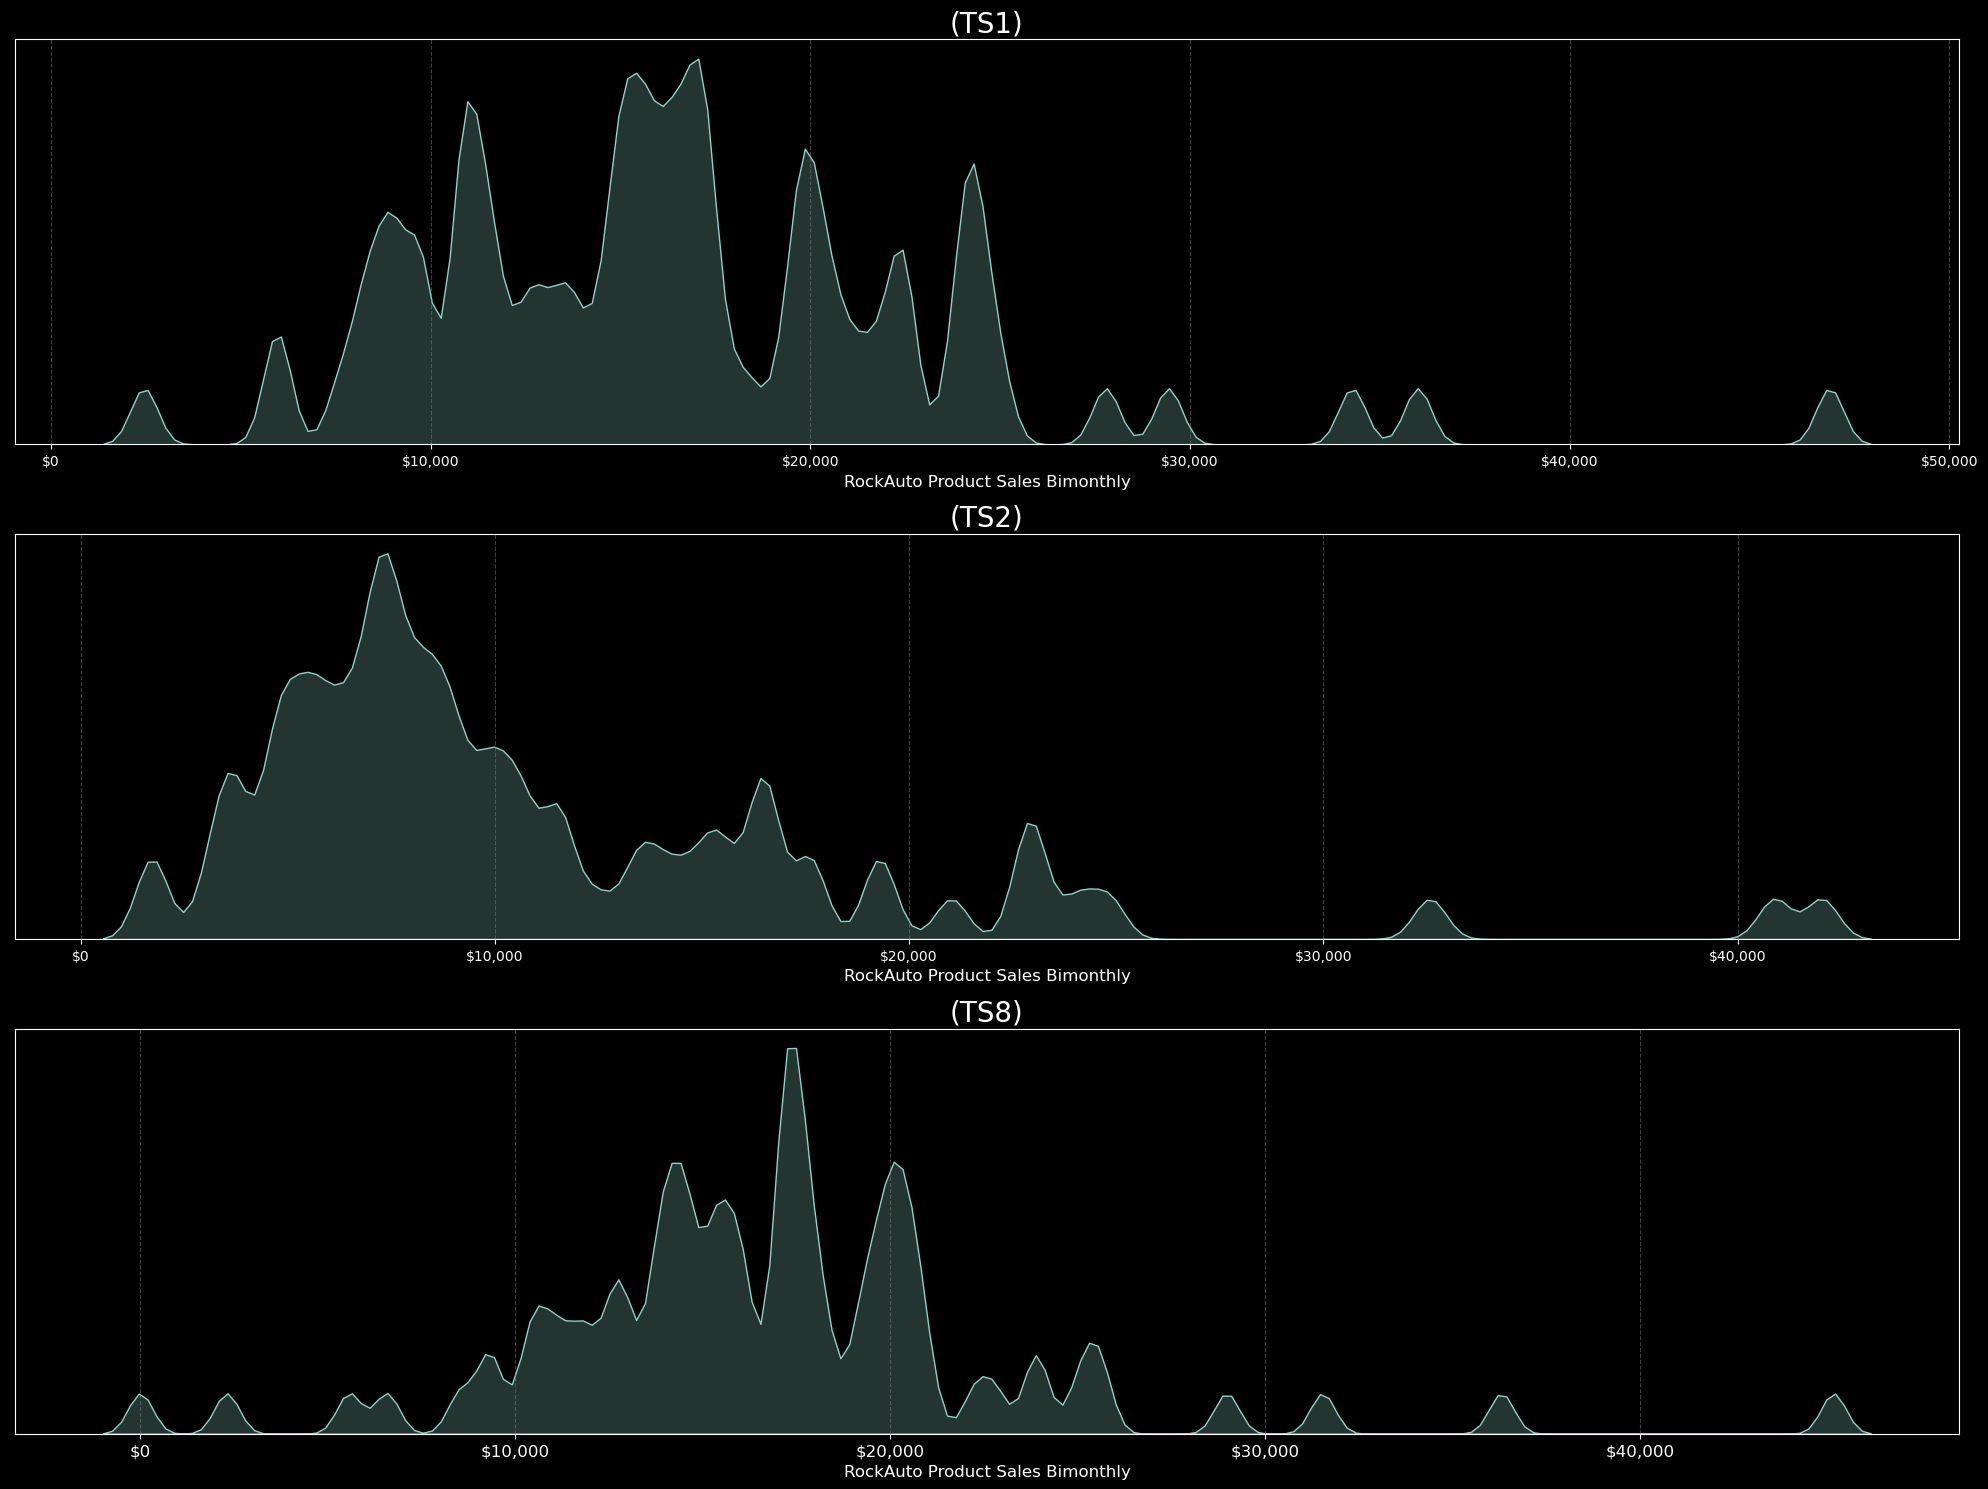

In [23]:
density_plot([skp_ts1, skp_ts2, skp_ts8], 'Cost', ['TS1', 'TS2', 'TS8'])

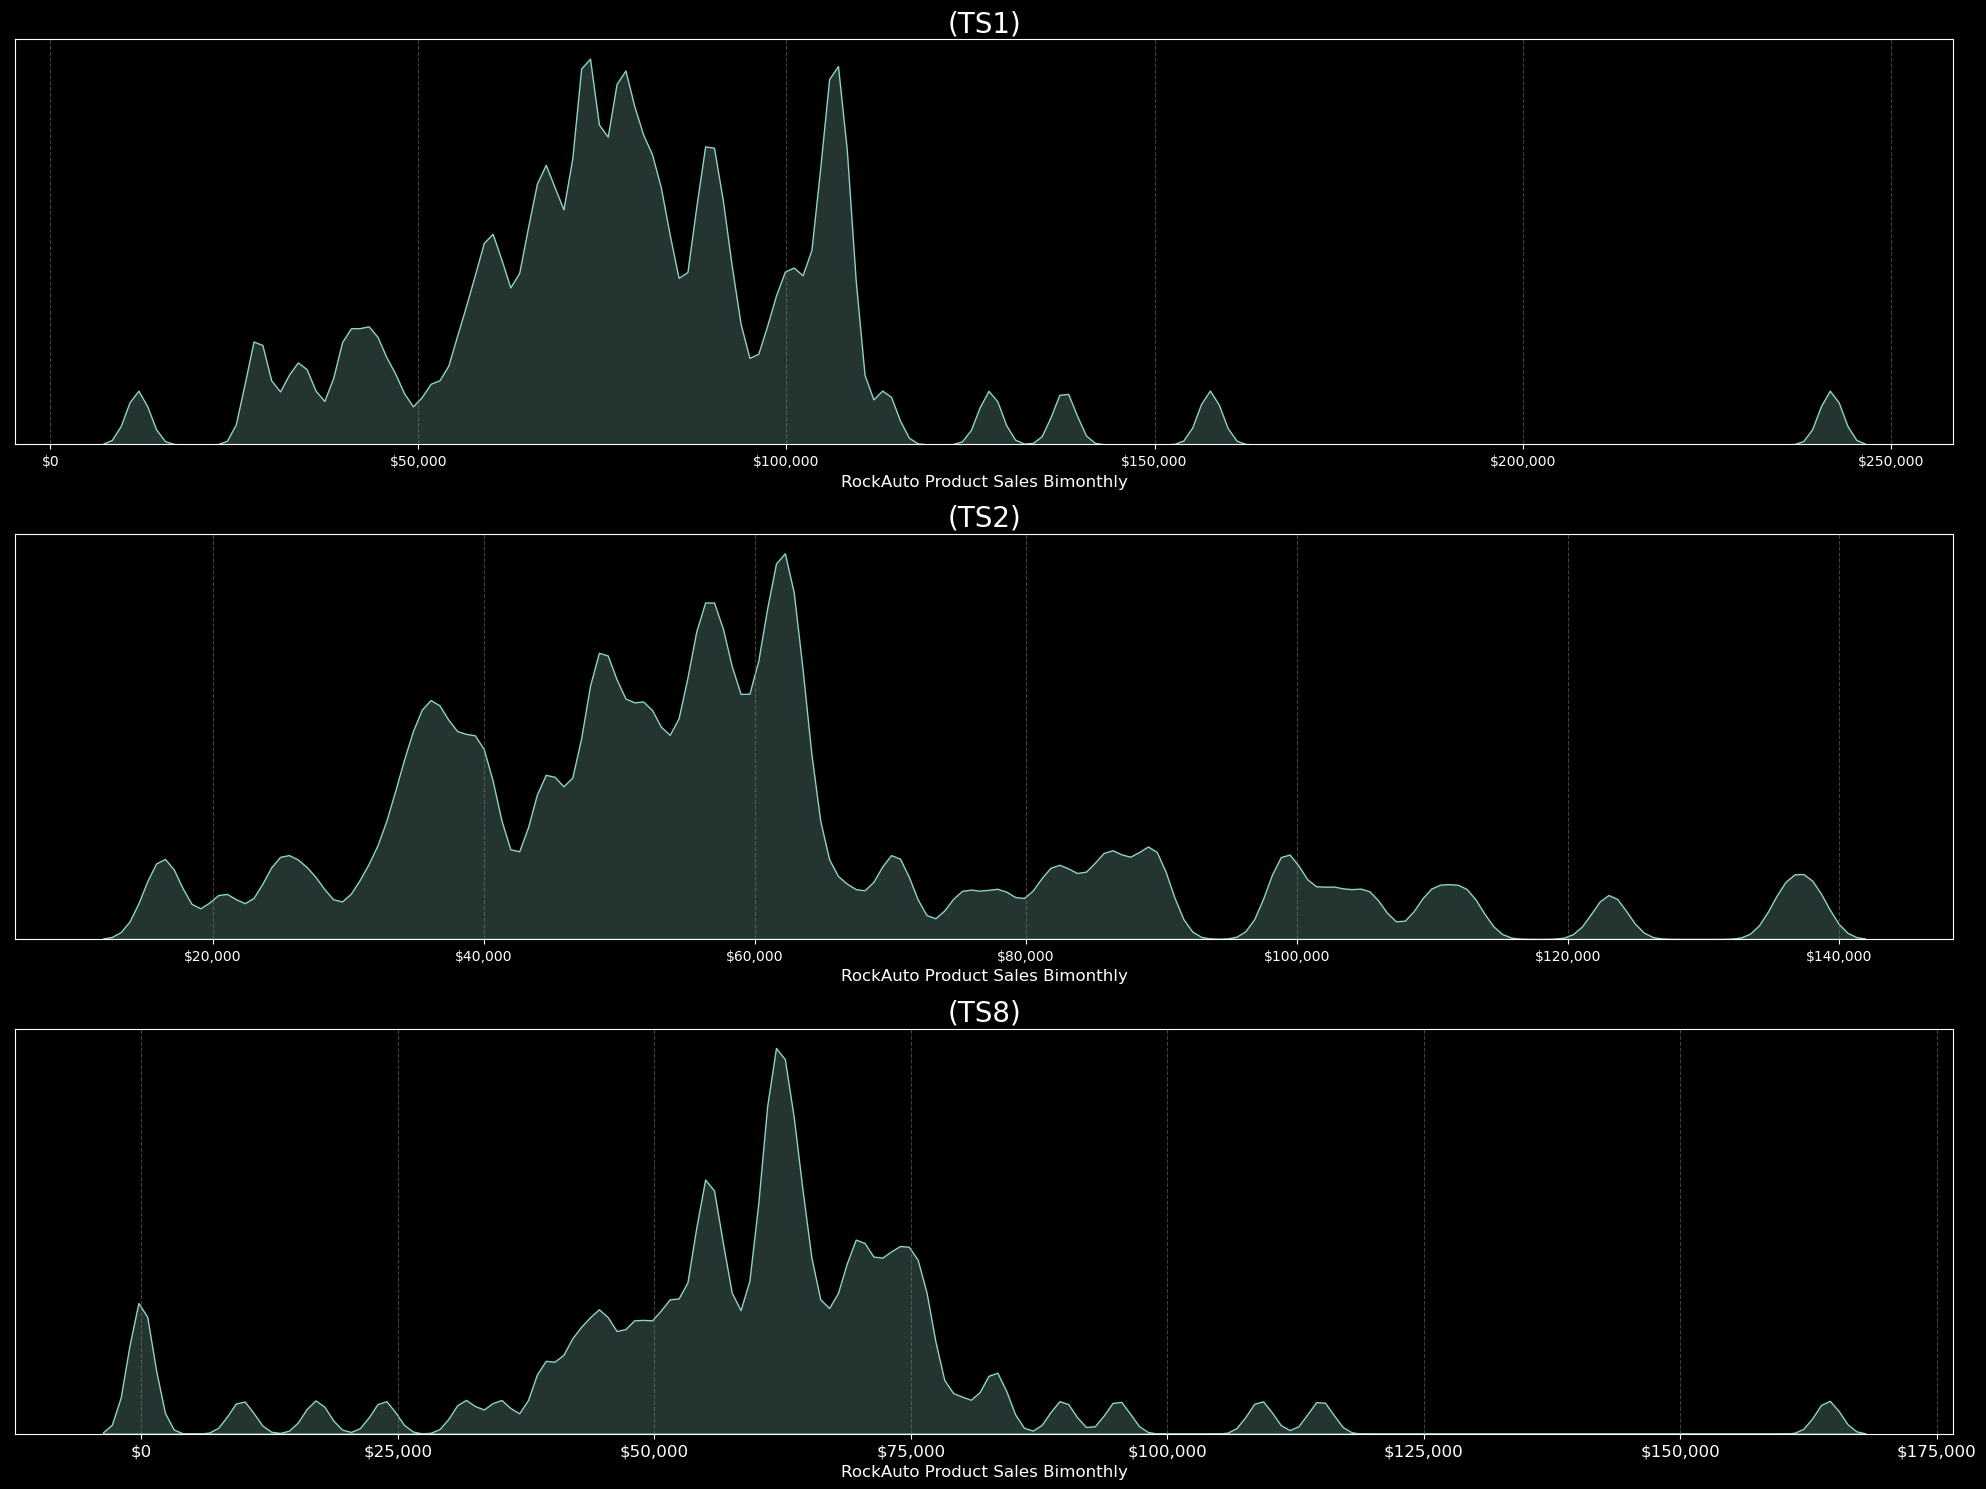

In [24]:
density_plot([plot_ts1, plot_ts2, plot_ts8], 'Cost', ['TS1', 'TS2', 'TS8'])

# Model Evaluation

In [25]:
# Creating a function that combines all dataframes into a single dataframe
def combine_dataframes(data_list):
    # Creating a new dataframe
    combined = pd.concat(data_list, ignore_index=True)
    return combined

df = combine_dataframes([ts1, ts2, ts8])
df.head()

,Part Number,Line,Time,Qty,Unit,Cost
0,ACC31019,1.0,08:22,1.0,308.74,262.33
1,ACC31029,2.0,16:33,1.0,296.23,248.63
2,ACC31109,1.0,15:23,1.0,283.15,237.97
3,ACC31109,1.0,08:28,1.0,283.15,236.97
4,ACC31129,1.0,15:27,1.0,283.15,243.50


In [28]:
X = df.drop(columns = ['Cost', 'Part Number'])
y = df['Cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [30]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat = make_column_selector(dtype_include='object')
num = make_column_selector(dtype_include='number')

preprocessor = make_column_transformer((scaler, num), (ohe, cat), remainder='passthrough')

preprocessor.fit(X_train)


ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CACFC44A90>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CACFC44A00>)])

In [31]:
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

X_train_proc.shape

(423954, 920)

In [32]:
# Custom function that plots learning cycles of model
def plot_history(history):
    
    metrics = history.history.keys()
    
    for i in metrics:
        if not 'val' in i:
            plt.plot(history.history[f'{i}'], label=f'{i}')
            if f'val_{i}' in metrics:
                plt.plot(history.history[f'val_{i}'], label=f'val_{i}')
            plt.legend()
            plt.title(f'{i}')
            plt.show()



In [33]:
input_dim=X_train_proc.shape[1]

model = Sequential()

model.add(Dense(128, activation='relu', input_dim=input_dim))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)
model.compile(loss='mse', optimizer='adam', metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

history = model.fit(X_train_proc, y_train, epochs=100, batch_size=128, validation_split=0.2, verbose=1, callbacks=[earlystop])
plot_history(history)

Epoch 1/100
2650/2650 [==============================] - 10s 3ms/step - loss: 583.4842 - mean_absolute_error: 8.8006 - root_mean_squared_error: 24.1554 - val_loss: 292.6745 - val_mean_absolute_error: 4.7010 - val_root_mean_squared_error: 17.1077
Epoch 2/100
2650/2650 [==============================] - 7s 2ms/step - loss: 390.7668 - mean_absolute_error: 6.8060 - root_mean_squared_error: 19.7678 - val_loss: 297.9385 - val_mean_absolute_error: 4.4521 - val_root_mean_squared_error: 17.2609
Epoch 3/100
2650/2650 [==============================] - 7s 3ms/step - loss: 333.7501 - mean_absolute_error: 6.3970 - root_mean_squared_error: 18.2688 - val_loss: 211.9872 - val_mean_absolute_error: 4.0915 - val_root_mean_squared_error: 14.5598
Epoch 4/100
2650/2650 [==============================] - 6s 2ms/step - loss: 288.7079 - mean_absolute_error: 5.7049 - root_mean_squared_error: 16.9914 - val_loss: 187.8149 - val_mean_absolute_error: 4.4020 - val_root_mean_squared_error: 13.7046
Epoch 5/100
2650/26

KeyboardInterrupt: 